# Tracking using image features

Testing the Elliptical Fourier Descriptors (EFD) similarity between instances of cells

In [285]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
import skimage
from skimage.io import imshow,  imsave
import matplotlib.pyplot as plt
import numpy as np
from pyefd import elliptic_fourier_descriptors
import seaborn as sns
import pandas as pd
plt.rcParams["figure.figsize"] = (7,7)

import cv2
def ffc(img, arg = 1100):
    if type(img) == da.core.Array:
        img = img.compute()
    # http://whitewell.sakura.ne.jp/OpenCV/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    dst = cv2.blur(img, (arg, arg)) 
    #The original image/Image after Mean filter × Average brightness
    avg_hist = img.mean()
    # perform ffc
    img = (img/dst)*avg_hist
    ## convert back to dtype uint16
    img = img.astype('u2')
    
    return img

def ffc_stack(img_stack):
    stack = []
    for img in tqdm(img_stack):
        img = ffc(img)
        stack.append(img)
    img_stack = da.stack(stack, axis = 0)
    return img_stack

### Load images from zarr and compress into max projections

In [292]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr/',)# chunks = gfp.chunks)

### Apply a flatfield correction to the intensity images

This will be implemented in the tiling stage in the future

In [293]:
gfp_c = ffc_stack(gfp)

  0%|          | 0/75 [00:00<?, ?it/s]

In [294]:
rfp_c = ffc_stack(rfp)

  0%|          | 0/75 [00:00<?, ?it/s]

In [296]:
gfp

dask.array<sum-aggregate, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [310]:
v = napari.Viewer()
v.add_image(gfp_c.astype('u1'))
v.add_image(rfp_c.astype('u1'))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'Image [1]' at 0x7f0865aae250>

In [312]:
viewer = napari.Viewer()
viewer.add_image(gfp_c.astype('u2'), name="gfp cleaned", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
viewer.add_image(rfp_c.astype('u2'), name="rfp _cLEAned", 
                # contrast_limits=[0,55], 
                 blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
viewer.add_tracks(visualise_tracks, name = 'tracks_filtered')
viewer.add_tracks(visualise_raw_tracks, name = 'tracks')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'tracks' at 0x7f090c5ddc10>

In [307]:
hist, bin_edges = np.histogram(rfp_c[0].compute().astype('u1'), bins = 2**16)

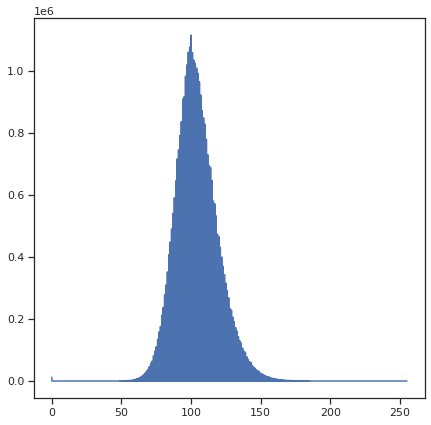

In [309]:
plt.plot(bin_edges[0:-1], hist)
# plt.xlim(300,800)

float64
Shape:(6048, 6048),type:uint8
Average Brightness:104.1


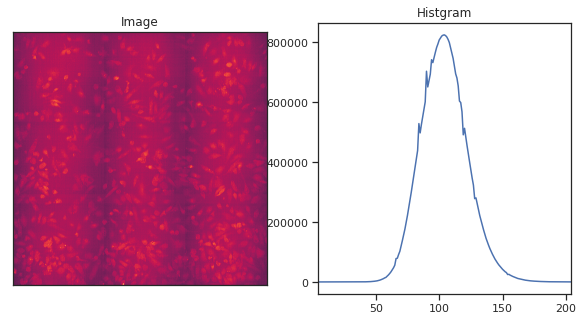

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


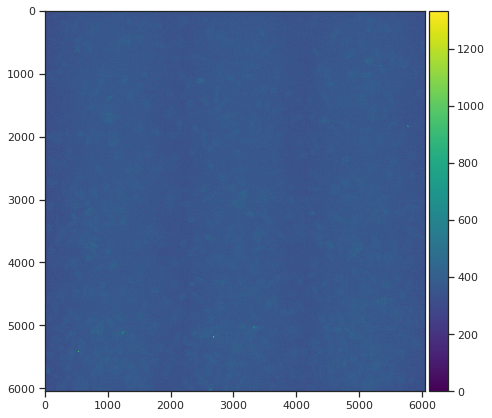

In [251]:
imshow(im)

In [253]:
imsave('test.jpg',im.astype('u1'))

#### Compress into multichannel image for btrack

In [3]:
image = da.stack([gfp, rfp], axis = -1)
image

dask.array<stack, shape=(75, 6048, 6048, 2), dtype=uint16, chunksize=(1, 2160, 2160, 1), chunktype=numpy.ndarray>

## Define features

In [4]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity",
    "intensity_image"
]

In [6]:
objects = btrack.utils.segmentation_to_objects(
    masks, 
    image,
    properties = tuple(FEATURES),
    use_weighted_centroid = False, 
)

[INFO][2022/11/11 01:00:01 PM] Localizing objects from segmentation...
[INFO][2022/11/11 01:00:01 PM] Found intensity_image data
[INFO][2022/11/11 01:07:25 PM] Objects are of type: <class 'dict'>
[INFO][2022/11/11 01:07:26 PM] ...Found 34804 objects in 75 frames.


#### Checking featuers were measured

In [7]:
objects[0]

{'ID': 0, 'x': 228.89178743961352, 'y': 53.54589371980676, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity-0': 1223.1384057971015, 'mean_intensity-1': 337.88864734299517, 'intensity_image': array([[[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       ...,

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=uint16)}

In [8]:
### finding the EFD
for obj in tqdm(objects):
    ### extract the intensity image (1ch only)
    glimpse = obj.properties['intensity_image'][...,0]
    ### pad the glimpse to ensure only one object is identifiable
    glimpse = np.pad(glimpse, pad_width = 1)
    ### find the contours (zero because only one object)
    contours = skimage.measure.find_contours(glimpse, fully_connected='high', level = 0.5)[0]
    ### get the efd
    efd = elliptic_fourier_descriptors(contours, order=100, normalize=True)
#     obj.properties = {'efd': efd}
    flatten_efd = efd.flatten()
    obj.properties = {'efd flat': flatten_efd}

  0%|          | 0/34804 [00:00<?, ?it/s]

## Remove intensity image from objects 

btrack does not handle 2d arrays in objects

In [9]:
for obj in tqdm(objects):
    obj.properties.pop('intensity_image')

  0%|          | 0/34804 [00:00<?, ?it/s]

In [10]:
objects[0]

{'ID': 0, 'x': 228.89178743961352, 'y': 53.54589371980676, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity-0': 1223.1384057971015, 'mean_intensity-1': 337.88864734299517, 'efd flat': array([ 1.00000000e+00,  5.04301835e-17,  1.14701462e-16, -6.09709389e-01,
        2.01976227e-02,  8.87153725e-03, -4.89990443e-02, -2.30932987e-02,
        4.96015509e-02,  2.22684140e-03,  1.97777233e-02, -6.52375860e-02,
       -1.61762974e-03,  4.21390024e-03,  6.80647690e-04, -3.76505429e-03,
        1.05512406e-02, -4.07975839e-04,  5.86517107e-04, -9.60494084e-03,
       -6.98005603e-03,  5.03815140e-03, -9.67077973e-04,  7.75433259e-03,
        3.51114072e-03, -6.58337802e-03, -1.87062801e-03,  3.27958217e-03,
        3.22977869e-04,  8.28085673e-03,  6.93344800e-03, -2.27455131e-03,
       -1.19519206e-03, -7.04011333e-03, -4.47416433e-03,  3.10420744e-04,
        2.68803249e-03,  5.93816998e-03,  2.13798631e-03,  1.03867541e-03,
       -2.72036474e-03, -3.42627101e-03,  1.01166469e-03, -1.39096609e-03,
        1.86584384e-03,  2.29004954e-03, -2.83302613e-03, -2.34922322e-04,
       -4.72931407e-04, -1.01812765e-03,  2.81674483e-03, -7.07489089e-04,
       -1.66482600e-03,  2.02827423e-03, -1.54457356e-04, -1.29588986e-03,
        2.57490199e-03, -1.27656143e-03, -1.81186695e-03,  2.07572955e-03,
       -1.41233818e-03,  1.42119967e-03,  2.51444308e-03, -1.29947872e-04,
        1.59962205e-03, -1.33302262e-03, -9.23309588e-04,  5.43618873e-05,
        2.62620014e-04,  1.01734811e-03, -1.03857862e-03,  1.52913514e-03,
        2.00747585e-04, -1.04091945e-04,  9.12398983e-04, -1.58627506e-03,
        8.68560221e-04, -6.04671434e-04, -1.77728274e-05, -2.21296486e-04,
       -1.15549792e-04,  1.03128782e-03,  1.79668554e-04,  6.31632075e-04,
        8.51758725e-04, -1.72974649e-03,  3.90995491e-04, -7.14500934e-04,
        1.16578563e-04,  1.05820726e-03, -6.81204958e-04,  1.28597457e-03,
        7.14805518e-04, -1.04273041e-03,  1.01359713e-03, -8.47485901e-04,
       -2.51396246e-04,  7.68356581e-04,  1.64672708e-04, -1.10066311e-03,
        8.92798183e-04, -3.29990031e-04, -8.54309126e-04,  1.10377098e-03,
       -1.01218781e-03,  4.28701126e-04,  2.83842823e-04, -3.14728090e-04,
        1.01534709e-03, -1.09306163e-04, -6.17853094e-04, -6.09944737e-04,
       -5.06543474e-04,  1.79488309e-04,  1.10643996e-03,  7.61548988e-04,
        4.21945913e-04,  5.31384440e-04,  7.53410906e-04,  2.03385206e-04,
       -5.08070414e-04, -2.86505392e-04, -2.20785493e-03,  1.94249606e-04,
        3.41898620e-04,  7.15824486e-04,  3.38721489e-05, -2.49267270e-04,
       -2.64607459e-04, -2.79842118e-04,  8.67219527e-04, -4.40285781e-04,
        5.34562152e-04,  1.63838452e-04,  7.29208121e-05,  2.47532970e-04,
        5.95851673e-05, -1.30993651e-04,  1.09116154e-03,  1.81898748e-04,
       -5.89545242e-04, -4.73526996e-04, -5.71898285e-04, -6.34270107e-04,
        8.99264166e-04, -5.06610494e-05, -1.67433931e-04, -1.99754939e-04,
       -6.11627418e-04, -2.14649652e-04,  5.60688844e-04,  4.48659166e-04,
        8.48051633e-04, -7.52024107e-04, -3.13138790e-04,  5.43722767e-05,
        1.21816208e-04,  7.53054683e-05,  3.18770775e-04,  7.02679137e-04,
        2.66734339e-04,  3.98417069e-05, -7.84266023e-05,  1.75608196e-04,
        6.44278393e-04, -5.46194395e-04, -8.14276429e-04, -4.19748909e-04,
        1.01580143e-04,  6.95019509e-04,  6.63031624e-04,  2.85621415e-04,
        1.87573001e-04, -6.32407813e-04, -1.13149742e-03, -3.78375538e-04,
        2.62121041e-04,  8.45593956e-04, -1.95384741e-05, -6.14103573e-04,
       -7.96252846e-05, -5.94504741e-05,  5.02920925e-04,  8.19084506e-04,
       -6.12751645e-05,  1.25976584e-04, -3.80003191e-04, -1.20860318e-03,
        1.44873222e-04,  6.53646454e-04,  8.17380757e-04, -2.40791973e-04,
       -8.20519315e-04, -1.57

## Save out objects if desired

In [14]:
with btrack.dataio.HDF5FileHandler(
     '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/objects.h5', 'w', obj_type='obj_type_1',
) as hdf:
    hdf.write_segmentation(masks)
    hdf.write_objects(objects)

[INFO][2022/11/11 01:21:35 PM] Opening HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/objects.h5...
[INFO][2022/11/11 01:22:12 PM] Writing objects/obj_type_1
[INFO][2022/11/11 01:22:12 PM] Writing labels/obj_type_1
[INFO][2022/11/11 01:22:12 PM] Loading objects/obj_type_1 (34804, 5) (34804 filtered: None)
[INFO][2022/11/11 01:22:12 PM] Writing properties/obj_type_1/area (34804,)
[INFO][2022/11/11 01:22:12 PM] Writing properties/obj_type_1/major_axis_length (34804,)
[INFO][2022/11/11 01:22:12 PM] Writing properties/obj_type_1/minor_axis_length (34804,)
[INFO][2022/11/11 01:22:12 PM] Writing properties/obj_type_1/orientation (34804,)
[INFO][2022/11/11 01:22:12 PM] Writing properties/obj_type_1/solidity (34804,)
[INFO][2022/11/11 01:22:12 PM] Writing properties/obj_type_1/mean_intensity-0 (34804,)
[INFO][2022/11/11 01:22:12 PM] Writing properties/obj_type_1/mean_intensity-1 (34804,)
[INFO][2022/11/11 01:22:13 PM] Writing properties/obj_type_1/efd flat

## Track

Redefine features to include `efd flat` and the two different `mean_intensity` channels

In [11]:
FEATURES = ['efd flat',
                     "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity-0",
  "mean_intensity-1",
]

In [13]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/particle_config.json'
    )
    tracker.verbose = True

    tracker.max_search_radius = 400
    
    # use visual features to track
    tracker.features = FEATURES
    
    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)
    tracker.track(tracking_updates =['visual', 'motion'], step_size=10)


    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

#     # get the tracks in a format for napari visualization (optional)
    visualise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[INFO][2022/11/11 01:17:38 PM] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/11/11 01:17:38 PM] btrack (v0.5.0) library imported
[INFO][2022/11/11 01:17:38 PM] Starting BayesianTracker session
[INFO][2022/11/11 01:17:38 PM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/11/11 01:17:38 PM] Setting max_search_radius -> 400
[INFO][2022/11/11 01:17:38 PM] Setting features -> ['efd flat', 'area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity', 'mean_intensity-0', 'mean_intensity-1']
[INFO][2022/11/11 01:17:38 PM] Objects are of type: <class 'list'>
[INFO][2022/11/11 01:17:39 PM] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/11/11 01:17:39 PM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/11/11 01:17:39 PM] Starting tracking... 
[INFO][2022/11/11 01:17:39 PM] Update using: ['MOTION']
[INFO][2022/11/11 01:17:39 PM]

GLPK Integer Optimizer 5.0
70416 rows, 58526 columns, 81844 non-zeros
58526 integer variables, all of which are binary
Preprocessing...
35208 rows, 58526 columns, 81844 non-zeros
58526 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 35208
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
35208 rows, 58526 columns, 81844 non-zeros
*     0: obj =   2.183635026e+05 inf =   0.000e+00 (19173)
Perturbing LP to avoid stalling [2020]...
*  5420: obj =   1.615439819e+05 inf =   0.000e+00 (13600)
* 10202: obj =   1.171120317e+05 inf =   0.000e+00 (8755)
* 13289: obj =   1.059710272e+05 inf =   0.000e+00 (5653) 1
* 16972: obj =   9.204462149e+04 inf =   0.000e+00 (2275) 1
Removing LP perturbation [19481]...
* 19481: obj =   8.868552819e+04 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step 

[INFO][2022/11/11 01:18:42 PM] Writing tracks/obj_type_1
[WARNING][2022/11/11 01:18:42 PM] Removing tracks/obj_type_1.
[INFO][2022/11/11 01:18:42 PM] Writing dummies/obj_type_1
[INFO][2022/11/11 01:18:42 PM] Writing LBEP/obj_type_1
[INFO][2022/11/11 01:18:42 PM] Writing fates/obj_type_1
[INFO][2022/11/11 01:18:42 PM] Closing HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5
[INFO][2022/11/11 01:18:53 PM] Ending BayesianTracker session


In [17]:
tracks[100]

OrderedDict([('ID', 331), ('t', [0, 1, 2, 3]), ('x', [2795.2296057709436, 2795.2296057709436, 2795.2296057709436, 2824.681350016361]), ('y', [1512.718770409072, 1512.718770409072, 1512.718770409072, 1501.0769434532622]), ('z', [0.0, 0.0, 0.0, 0.0]), ('parent', 331), ('root', 331), ('state', [5, 5, 5, 5]), ('generation', 0), ('dummy', [False, True, True, False]), ('solidity', array([0.91813734,        nan,        nan, 0.91720737])), ('minor_axis_length', array([142.39416424,          nan,          nan, 112.02990314])), ('major_axis_length', array([665.88233263,          nan,          nan, 754.81175523])), ('mean_intensity-0', array([1407.57621861,           nan,           nan, 1358.88430435])), ('efd flat', array([[ 1.00000000e+00, -5.21066943e-17,  2.47377531e-17, ...,
        -4.74975531e-05, -8.35486366e-05,  2.54246886e-05],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.00000000e+00, -9.68344496e-18,  1.91201404e-17, ...,
         1.39758483e-05, -6.98092223e-05, -2.29226254e-05]])), ('area', array([67372.,    nan,    nan, 64177.])), ('mean_intensity-1', array([373.50185537,          nan,          nan, 372.54290478])), ('orientation', array([-0.79668699,         nan,         nan, -0.84786608]))])

In [15]:
print(tracks[0].properties['area'])

[21286.    nan 25428.]


In [15]:
print(tracks[0].properties['area'])

[1]


(array([1.2777e+04, 1.3550e+03, 3.6700e+02, 1.5900e+02, 4.5000e+01,
        1.9000e+01, 1.1000e+01, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 1. ,  8.1, 15.2, 22.3, 29.4, 36.5, 43.6, 50.7, 57.8, 64.9, 72. ]),
 <BarContainer object of 10 artists>)

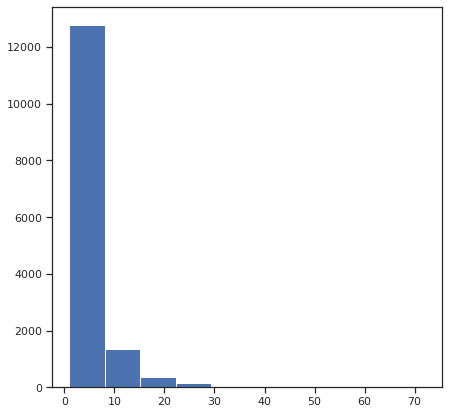

In [135]:
plt.hist([len(track) for track in tracks])

In [18]:
len([len(track) for track in tracks if len(track) > 15])

606

(array([336., 157.,  55.,  32.,  10.,   9.,   3.,   1.,   1.,   2.]),
 array([16. , 21.6, 27.2, 32.8, 38.4, 44. , 49.6, 55.2, 60.8, 66.4, 72. ]),
 <BarContainer object of 10 artists>)

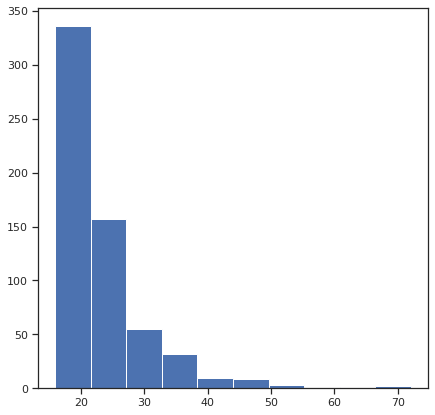

In [136]:
plt.hist([len(track) for track in tracks if len(track) > 15])

### Filter tracks

In [21]:
tracks_filt = [track for track in tracks if len(track) > 15]
visualise_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [22]:
visualise_raw_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [23]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
viewer.add_image(rfp, name="rfp", 
                # contrast_limits=[0,55], 
                 blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
viewer.add_tracks(visualise_tracks, name = 'tracks_filtered')
viewer.add_tracks(visualise_raw_tracks, name = 'tracks')


Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'tracks' at 0x7f0ac1b4fc40>

### Prime tracks

(Greater than 50 frames length)

In [137]:
prime_tracks = [track for track in tracks if len(track) > 50]

In [139]:
track = prime_tracks[0]

In [140]:
track

OrderedDict([('ID', 126), ('t', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]), ('x', [3902.424743019149, 3902.424743019149, 3902.424743019149, 3906.1896126348392, 3897.1246974393816, 3897.1246974393816, 3922.647802621434, 3914.551396460309, 3921.524144287418, 3937.5307989844428, 3939.6826882328014, 3945.342600246134, 3951.002512259467, 3956.6624242728, 3962.3223362861327, 3941.338525340239, 3938.656647121215, 3944.8004145307846, 3951.3842318883553, 3951.688635713264, 3955.068244521178, 3950.48645519402, 3948.928407363621, 3948.287560082796, 3950.796259949842, 3950.807977991747, 3952.8148484285207, 3942.501771599891, 3951.487251620255, 3949.3327723235157, 3955.76514014235, 3952.3432097867776, 3954.672650090964, 3953.7693042943947, 3953.7392593085992, 3957.1162962113644, 3957.9980012523883, 3954.4587954834196, 3949.2555209493075, 3946.6952709032353, 3944.135020857163, 3954.7350064154743, 3928.8932308915087, 3934.1218182062407, 3937.769187801716, 3935.6931796914687, 3935.4865633684653, 3930.677805400545, 3932.145852081881, 3930.0077872483807, 3930.8280973630517, 3918.8231226378925, 3913.052556864717, 3922.6253440148234, 3923.579695528553, 3924.534047042283, 3927.5300529385886, 3924.6655615018412, 3921.801070065094, 3918.9365786283465, 3921.932412514264, 3919.4984569280314, 3933.169840937631, 3940.9612659718705, 3938.711935166994, 3936.676796562225, 3935.7453051917696, 3932.431339890612]), ('y', [4481.177534567686, 4481.177534567686, 4481.177534567686, 4502.385060058708, 4508.973332200942, 4508.973332200942, 4511.6636468774095, 4518.258307818684, 4520.239653739111, 4517.28059024997, 4527.291619579037, 4531.8440904172385, 4536.39656125544, 4540.949032093642, 4545.501502931844, 4539.94824867117, 4539.151253777342, 4534.620574791346, 4537.977370869396, 4535.148465445701, 4532.036733702348, 4540.33723246667, 4539.273197095085, 4538.6931715349865, 4543.634845345837, 4549.867381934892, 4552.555998392046, 4541.916158248947, 4546.19597963108, 4554.051425899953, 4539.599512548348, 4543.758366204352, 4534.335077536169, 4534.828394893152, 4533.682941450743, 4530.560727916005, 4529.635252715827, 4526.444492027465, 4523.834815451612, 4520.5614608738215, 4517.288106296031, 4528.658489811123, 4541.376192210889, 4532.468964498234, 4525.514472823168, 4529.352632141807, 4533.050613496933, 4531.611977995822, 4530.832245389442, 4537.4364228575705, 4539.626485249611, 4535.1005915539245, 4531.532868342496, 4536.852230306003, 4539.234672251678, 4541.617114197353, 4522.499396812331, 4518.693668313101, 4514.887939813871, 4511.0822113146405, 4521.243295930011, 4518.470427184551, 4533.1686150810265, 4540.7416314012835, 4533.789320017463, 4531.842193127541, 4530.4225833840665, 4513.086947714331]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9715152410304384, 3.943030482060877, 5.914545723091315, 7.886060964121754, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.2264645703053505, 0.0, 0.0, 1.4602067276124489, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25901119251674043, 0.0, 0.0, -1.855402287947495, -3.71080457589499, 0.0, 0.0, 0.0, -0.27407089057374695, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3447603564132578, 0.0, -3.8639658777508896, 0.0, 1.94710086902056, 3.89420173804112, 0.0, -2.60997861370791, -5.21995722741582, -7.8299358411237305, 0.0, -1.6869961717498532, 0.0, 7.415030279398843, 0.0, 0.0, -1.4288652203656715, 0.0]), ('parent', 126), ('root', 126), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, True, True, False, False, True, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, Fa

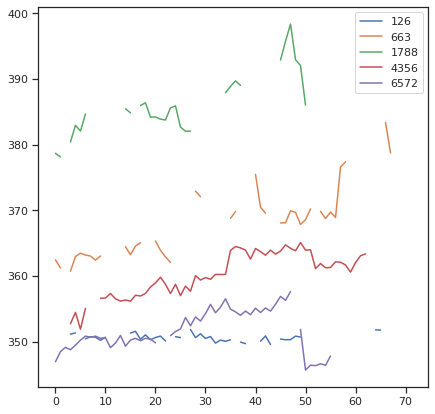

In [141]:
for track in prime_tracks:
    plt.plot(track.properties['mean_intensity-1'], label = track.ID)
plt.legend()

In [1]:
prime_tracks = [track for track in tracks if len(track) > 45]

NameError: name 'tracks' is not defined

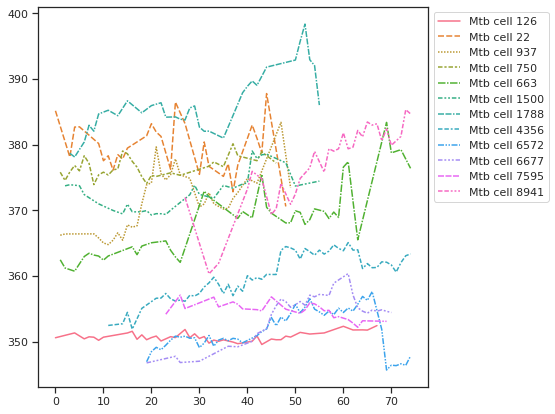

In [172]:
dfs = []
for track in prime_tracks:
    x = track.t
    y = track.properties['mean_intensity-1']
    d = {f'Mtb cell {track.ID}':y}
    df = pd.DataFrame(data=d, index = x)
    dfs.append(df)
df = pd.concat(dfs)
ax = sns.lineplot(data = df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

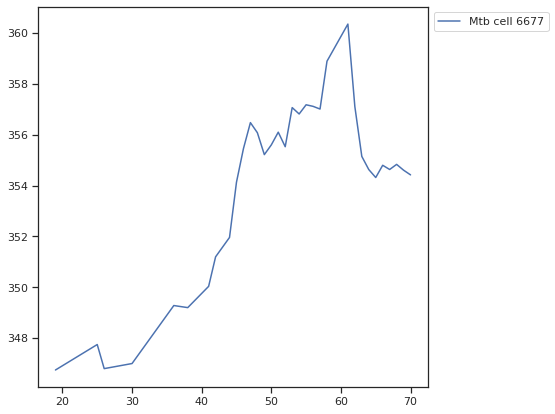

In [174]:
dfs = []
for track in prime_tracks:
    if track.ID != 6677:
        continue
    x = track.t
    y = track.properties['mean_intensity-1']
    d = {f'Mtb cell {track.ID}':y}
    df = pd.DataFrame(data=d, index = x)
    dfs.append(df)
df = pd.concat(dfs)
ax = sns.lineplot(data = df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [43]:
track = [track for track in tracks if track.ID == 4356][0]

In [44]:
track

OrderedDict([('ID', 4356), ('t', [11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]), ('x', [3604.4930680738094, 3604.4930680738094, 3604.4930680738094, 3613.025078211727, 3621.0901845413214, 3636.5615280376846, 3608.9137762465666, 3608.9137762465666, 3608.9137762465666, 3623.3640315676835, 3628.56012145749, 3632.012092157985, 3630.5972648618476, 3629.811887254902, 3633.8652252003317, 3625.549527158099, 3632.7715409836064, 3629.4622585876455, 3624.8236653570602, 3622.8996459107, 3623.8416097470927, 3628.4828578906045, 3631.723137658771, 3633.668078175896, 3636.3087187263077, 3627.7110255175735, 3632.428641251222, 3636.83792741088, 3635.623874229736, 3631.752012615155, 3633.8469387755104, 3635.8707509122337, 3633.366145450729, 3634.2206178643387, 3636.3811233352635, 3636.938744042613, 3636.0299044935023, 3636.398537972113, 3638.792032250415, 3642.091492776886, 3640.0643828960156, 3636.858019281332, 3643.7479338842977, 3642.216495923061, 3643.3667977018445, 3635.30343166767, 3634.1092824887105, 3625.3267242999436, 3625.8972839069274, 3626.827239311279, 3634.3733898158553, 3637.869588793493, 3644.9541421417903, 3643.481985518625, 3646.4532543418277, 3642.3443212466286, 3641.9405744470123, 3644.929686130107, 3648.36554245635, 3642.3076409743076, 3640.3480633802815, 3640.4684452621896, 3640.0538998097654]), ('y', [55.92838648356331, 55.92838648356331, 55.92838648356331, 44.735694822888284, 49.87301417491308, 44.243337420145835, 51.31486568275991, 51.31486568275991, 51.31486568275991, 49.22512038523274, 48.6365721997301, 45.88058099599313, 47.416620150711694, 48.96881808278867, 47.51609560652114, 52.63215324927255, 48.0096393442623, 43.52933805100988, 44.72482859563978, 41.0226271698765, 42.58039505261215, 46.123964058274446, 45.34646412633025, 45.70936482084691, 50.21508718726308, 42.95926817525277, 42.15073313782991, 48.27119877132002, 49.03357560436088, 45.62395219520292, 41.518367346938774, 43.82369886690993, 42.48798404869346, 38.0810387284531, 36.874464389114074, 37.14648163723017, 32.445436041960235, 39.960741843779616, 39.62651173820252, 42.375708935259496, 39.75813896987366, 40.046074871666455, 43.60509269600179, 47.31915116035961, 50.00715653663945, 50.385711418824, 50.080280983442044, 52.040311971433944, 48.64513845881624, 46.38711549622751, 48.66707011325322, 49.28883868052417, 53.48827198453834, 51.457471866003665, 54.04090245090083, 57.30723703925682, 57.69800264113569, 53.79615991583377, 58.11953439785107, 53.767267267267265, 46.72869718309859, 48.545998160073594, 48.33263882598062]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 4356), ('root', 4356), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, True, True, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]), ('solidity', array([0.97682087,        nan,        nan, 0.99015738, 0.98894414,
       0.98719582, 0.98863113,        nan,        nan, 0.987061  ,
       0.99044309, 0.98868138, 0.98861833, 0.98855835, 0.98967663,
       0.9830165

# Why am i getting so many false positive dummy objects?

In [45]:
objects

[{'ID': 0, 'x': 228.89178743961352, 'y': 53.54589371980676, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity-0': 1223.1384057971015, 'mean_intensity-1': 337.88864734299517, 'efd flat': array([ 1.00000000e+00,  5.04301835e-17,  1.14701462e-16, -6.09709389e-01,
         2.01976227e-02,  8.87153725e-03, -4.89990443e-02, -2.30932987e-02,
         4.96015509e-02,  2.22684140e-03,  1.97777233e-02, -6.52375860e-02,
        -1.61762974e-03,  4.21390024e-03,  6.80647690e-04, -3.76505429e-03,
         1.05512406e-02, -4.07975839e-04,  5.86517107e-04, -9.60494084e-03,
        -6.98005603e-03,  5.03815140e-03, -9.67077973e-04,  7.75433259e-03,
         3.51114072e-03, -6.58337802e-03, -1.87062801e-03,  3.27958217e-03,
         3.22977869e-04,  8.28085673e-03,  6.93344800e-03, -2.27455131e-03,
        -1.19519206e-